In [ ]:
%pip install pandas matplotlib seaborn numpy scipy statsmodels
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm

Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 53.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 87.9 MB/s  0:00:006m0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 76.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 78.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 62.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 57.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━  5/11 [fonttools]  WARNING: The scripts fonttools, pyftmerge, pyftsubset and ttx are installed in '/usr/local/python/3.12.1/bin' which is not on PATH.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11/11 [seaborn]0/11 [seaborn]els]
Note: you may need to restart the kernel to use updated packages.


In [8]:
# paths (workspace)
sales_path = "/workspaces/TeamCPH/data/umsatzdaten_gekuerzt.csv"
wetter_path = "/workspaces/TeamCPH/data/wetter1.csv"
kiwo_path = "/workspaces/TeamCPH/data/kiwo.csv"
holidays_path = "/workspaces/TeamCPH/data/school_holidays_SH.csv"
test_path = "/workspaces/TeamCPH/data/test.csv"

In [ ]:
# load sales and aggregate to daily total
sales = pd.read_csv(sales_path, parse_dates=["Datum"])
sales_daily = sales.groupby("Datum", as_index=False)["Umsatz"].sum()

# load weather and kieler-week flags
wetter = pd.read_csv(wetter_path, parse_dates=["Datum"])
kiwo = pd.read_csv(kiwo_path, parse_dates=["Datum"])
holidays = pd.read_csv(holidays_path, parse_dates=["Datum"])
test = pd.read_csv(test_path, parse_dates=["Datum"])

# merge: sales <- weather <- kiwo
merged = sales_daily.merge(wetter, on="Datum", how="left")
merged = merged.merge(kiwo, on="Datum", how="left")
merged = merged.merge(holidays, on="Datum", how="left")
merged = merged.merge(test, on="Datum", how="left") 

# add test data to main data
merged = pd.concat([merged, test], ignore_index=True).drop_duplicates(subset=["Datum"], keep="last")

In [ ]:
# fill missing KielerWoche as 0 (not festival) and sort
merged["KielerWoche"] = merged["KielerWoche"].fillna(0).astype(int)
merged = merged.sort_values("Datum").reset_index(drop=True)

# extract year-month and aggregate
merged["YearMonth"] = merged["Datum"].dt.to_period("M")

# group by month: sum revenue and count KielerWoche days
monthly = merged.groupby("YearMonth").agg({
    "Umsatz": "sum",
    "KielerWoche": "sum"
}).reset_index()

# convert YearMonth back to timestamp for plotting
monthly["YearMonth"] = monthly["YearMonth"].dt.to_timestamp()

# create variable IsWeekend
merged['IsWeekend'] = merged["Datum"].dt.weekday.isin([5, 6]).astype(int)

# create variable IsNewYears (Dec 31)
merged["IsNewYears"] = merged["Datum"].dt.strftime("%m-%d").isin(["12-31"]).astype(int)

# create variable IsHalloween (Oct 31)
halloween_days = [f"10-{day:02d}" for day in range(24, 32)]

merged["IsHalloween"] = merged["Datum"].dt.strftime("%m-%d").isin(halloween_days).astype(int)


# Fourier
# day-of-year (handles leap years via 365.25)
merged["DayOfYear"] = merged["Datum"].dt.dayofyear

# yearly seasonality: 1st harmonic (smooth annual cycle)
merged["sin_1y"] = np.sin(2 * np.pi * merged["DayOfYear"] / 365.25)
merged["cos_1y"] = np.cos(2 * np.pi * merged["DayOfYear"] / 365.25)

# yearly seasonality: 2nd harmonic (captures sharper seasonal peaks/troughs)
merged["sin_2y"] = np.sin(4 * np.pi * merged["DayOfYear"] / 365.25)
merged["cos_2y"] = np.cos(4 * np.pi * merged["DayOfYear"] / 365.25)

# Optional: weekly seasonality (if you want more than just IsWeekend)
# This helps capture Mon/Tue/Wed patterns beyond weekend vs weekday
merged["DayOfWeek"] = merged["Datum"].dt.weekday  # 0=Mon ... 6=Sun
merged["sin_1w"] = np.sin(2 * np.pi * merged["DayOfWeek"] / 7)
merged["cos_1w"] = np.cos(2 * np.pi * merged["DayOfWeek"] / 7)


# TIME STRUCTURE (LAGGED REVENUE)
# 1-day lag (short-term persistence)
merged["Revenue_lag1"] = merged["Umsatz"].shift(1)

# 7-day lag (weekly habit / repetition)
merged["Revenue_lag7"] = merged["Umsatz"].shift(7)


# result
print(merged.head())
# optionally save
# merged.to_csv("/workspaces/TeamCPH/merged_daily.csv", index=False)

       Datum       Umsatz  Bewoelkung  Temperatur  Windgeschwindigkeit  \
0 2013-07-01  1269.249107         6.0     17.8375                 15.0   
1 2013-07-02  1430.008397         3.0     17.3125                 10.0   
2 2013-07-03  1124.274894         7.0     21.0750                  6.0   
3 2013-07-04  1184.309567         7.0     18.8500                  7.0   
4 2013-07-05  1288.023060         5.0     19.9750                 12.0   

   Wettercode  WeatherCategory  KielerWoche  holiday  Easter  ...  DayOfYear  \
0        20.0              3.0            0      1.0     0.0  ...        182   
1         NaN              1.0            0      1.0     0.0  ...        183   
2        61.0              4.0            0      1.0     0.0  ...        184   
3        20.0              3.0            0      1.0     0.0  ...        185   
4         NaN              1.0            0      1.0     0.0  ...        186   

     sin_1y    cos_1y    sin_2y    cos_2y  DayOfWeek    sin_1w    cos_1w  

In [11]:
# translate column names to English
merged.rename(columns={'Datum': 'Date'}, inplace=True)
merged.rename(columns={'Umsatz': 'Revenue'}, inplace=True)
merged.rename(columns={'Bewoelkung': 'CloudCover'}, inplace=True)
merged.rename(columns={'Temperatur': 'Temperature'}, inplace=True)
merged.rename(columns={'Windgeschwindigkeit': 'WindSpeed'}, inplace=True)
merged.rename(columns={'Wettercode': 'WeatherCode'}, inplace=True)
merged.rename(columns={'KielerWoche': 'KielWeek'}, inplace=True)
print(merged)

           Date      Revenue  CloudCover  Temperature  WindSpeed  WeatherCode  \
0    2013-07-01  1269.249107         6.0      17.8375       15.0         20.0   
1    2013-07-02  1430.008397         3.0      17.3125       10.0          NaN   
2    2013-07-03  1124.274894         7.0      21.0750        6.0         61.0   
3    2013-07-04  1184.309567         7.0      18.8500        7.0         20.0   
4    2013-07-05  1288.023060         5.0      19.9750       12.0          NaN   
...         ...          ...         ...          ...        ...          ...   
2169 2019-07-26          NaN         NaN          NaN        NaN          NaN   
2170 2019-07-27          NaN         NaN          NaN        NaN          NaN   
2171 2019-07-28          NaN         NaN          NaN        NaN          NaN   
2172 2019-07-29          NaN         NaN          NaN        NaN          NaN   
2173 2019-07-30          NaN         NaN          NaN        NaN          NaN   

      WeatherCategory  Kiel

In [12]:
#descriptive statistics for key variables
stats = merged[['Revenue', 'CloudCover','Temperature','WindSpeed']].describe()
print('Descriptive statistics for key variables:')
print(stats)

Descriptive statistics for key variables:
           Revenue   CloudCover  Temperature    WindSpeed
count  1819.000000  1807.000000   1816.00000  1816.000000
mean   1060.910160     4.688434     12.20778    10.996696
std     290.267632     2.650726      7.26073     4.128913
min     525.973832     0.000000     -8.47500     3.000000
25%     850.806263     3.000000      6.37500     8.000000
50%    1001.424738     6.000000     12.04375    10.000000
75%    1226.344892     7.000000     18.12500    13.000000
max    3156.413344     8.000000     31.43750    35.000000


In [ ]:
#cleaning dataset 

# remove rows containing NaN values
nan_per_column = merged.isnull().sum()
print('NaN values in each column:')
print(nan_per_column)

# Clean NaN values only for rows before positional index 1819 (iloc)
cutoff_pos = 1819
n_rows = len(merged)

if cutoff_pos <= 0:
    # nothing to clean before 0
    merged_cleaned = merged.copy()
elif cutoff_pos >= n_rows: # cutoff beyond end -> clean whole dataframe
    merged_cleaned = merged.dropna(subset=['CloudCover', 'Temperature', 'WindSpeed'], how='any')
else:
    # split by positional index: pre (0..cutoff_pos-1) and post (cutoff_pos..end)
    pre = merged.iloc[:cutoff_pos].dropna(subset=['CloudCover', 'Temperature', 'WindSpeed'], how='any')
    post = merged.iloc[cutoff_pos:]
    # concat preserving original indices and order
    merged_cleaned = pd.concat([pre, post]).sort_index()

print('Original shape:', merged.shape)
print('Shape after selective cleaning:', merged_cleaned.shape)
print(merged_cleaned.head())

nan_per_column = merged_cleaned.isnull().sum()
print('NaN values in each column:')
print(nan_per_column)


NaN values in each column:
Date                  0
Revenue             355
CloudCover          367
Temperature         358
WindSpeed           358
WeatherCode         814
WeatherCategory     358
KielWeek              0
holiday             355
Easter              355
id                 1819
Warengruppe        1819
YearMonth             0
IsWeekend             0
IsNewYears            0
IsHalloween           0
DayOfYear             0
sin_1y                0
cos_1y                0
sin_2y                0
cos_2y                0
DayOfWeek             0
sin_1w                0
cos_1w                0
Revenue_lag1        355
Revenue_lag7        355
dtype: int64
Original shape: (2174, 26)
Shape after selective cleaning: (2162, 26)
        Date      Revenue  CloudCover  Temperature  WindSpeed  WeatherCode  \
0 2013-07-01  1269.249107         6.0      17.8375       15.0         20.0   
1 2013-07-02  1430.008397         3.0      17.3125       10.0          NaN   
2 2013-07-03  1124.274894       

In [36]:
print(merged_cleaned.head(10))

        Date      Revenue  CloudCover  Temperature  WindSpeed  WeatherCode  \
0 2013-07-01  1269.249107         6.0      17.8375       15.0         20.0   
1 2013-07-02  1430.008397         3.0      17.3125       10.0          NaN   
2 2013-07-03  1124.274894         7.0      21.0750        6.0         61.0   
3 2013-07-04  1184.309567         7.0      18.8500        7.0         20.0   
4 2013-07-05  1288.023060         5.0      19.9750       12.0          NaN   
5 2013-07-06  1540.529898         0.0      18.9625        8.0          NaN   
6 2013-07-07  1532.372927         0.0      21.3750        9.0          NaN   
7 2013-07-08  1203.921695         0.0      22.7250       10.0          5.0   
8 2013-07-09  1385.112329         0.0      23.2750        8.0          NaN   
9 2013-07-10  1384.765939         2.0      19.6875       13.0          5.0   

   WeatherCategory  KielWeek  holiday  Easter  ...  DayOfYear    sin_1y  \
0              3.0         0      1.0     0.0  ...        182  0.0

  weekday     Revenue
   Monday  993.311731
  Tuesday  965.657881
Wednesday  957.760869
 Thursday  996.287439
   Friday 1008.074795
 Saturday 1235.966898
   Sunday 1273.243223


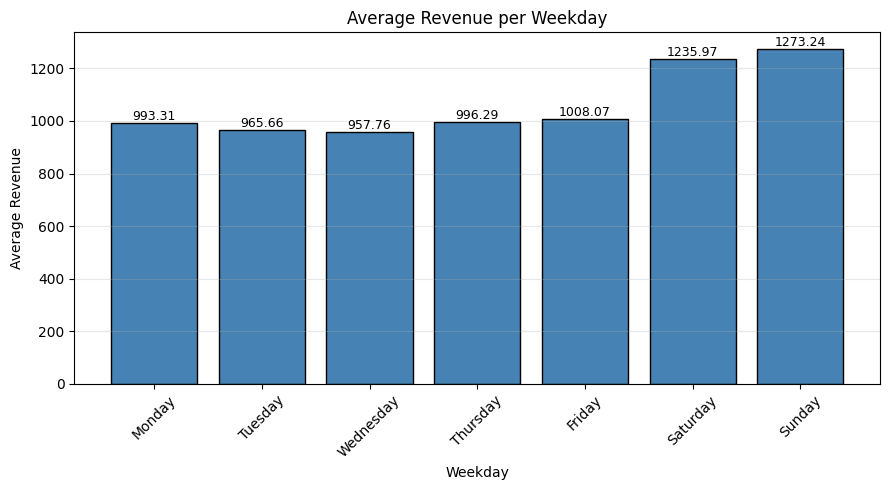

In [15]:
# determine column names 
if 'merged_cleaned' not in globals():
    raise KeyError("DataFrame 'merged_cleaned' not found in the notebook namespace.")

revenue_col = 'Revenue' if 'Revenue' in merged_cleaned.columns else ('Umsatz' if 'Umsatz' in merged_cleaned.columns else None)
date_col = 'Date' if 'Date' in merged_cleaned.columns else ('Datum' if 'Datum' in merged_cleaned.columns else None)

if revenue_col is None:
    raise KeyError("Keine Spalte 'Umsatz' oder 'Revenue' in merged_cleaned gefunden.")
if date_col is None:
    raise KeyError("Keine Spalte 'Datum' oder 'Date' in merged_cleaned gefunden.")

# ensure date column is datetime
merged_cleaned[date_col] = pd.to_datetime(merged_cleaned[date_col])

# prepare aggregated data: average revenue per weekday (Mon-Sun)
df = merged_cleaned[[date_col, revenue_col]].copy()
df['weekday_num'] = df[date_col].dt.weekday 
df['weekday'] = df[date_col].dt.day_name()

avg_by_weekday = df.groupby(['weekday_num', 'weekday'])[revenue_col].mean().reset_index()
avg_by_weekday = avg_by_weekday.sort_values('weekday_num')

# show table
print(avg_by_weekday[['weekday', revenue_col]].to_string(index=False))

# plot
fig, ax = plt.subplots(figsize=(9,5))
bars = ax.bar(avg_by_weekday['weekday'], avg_by_weekday[revenue_col], color='steelblue', edgecolor='black')
ax.set_xlabel('Weekday')
ax.set_ylabel(f'Average {revenue_col}')
ax.set_title('Average Revenue per Weekday')
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)

# annotate values above bars
for bar, val in zip(bars, avg_by_weekday[revenue_col]):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{val:.2f}", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [16]:
df = merged_cleaned
print(df.head())    

        Date      Revenue  CloudCover  Temperature  WindSpeed  WeatherCode  \
0 2013-07-01  1269.249107         6.0      17.8375       15.0         20.0   
1 2013-07-02  1430.008397         3.0      17.3125       10.0          NaN   
2 2013-07-03  1124.274894         7.0      21.0750        6.0         61.0   
3 2013-07-04  1184.309567         7.0      18.8500        7.0         20.0   
4 2013-07-05  1288.023060         5.0      19.9750       12.0          NaN   

   WeatherCategory  KielWeek  holiday  Easter  ...  DayOfYear    sin_1y  \
0              3.0         0      1.0     0.0  ...        182  0.010751   
1              1.0         0      1.0     0.0  ...        183 -0.006451   
2              4.0         0      1.0     0.0  ...        184 -0.023651   
3              3.0         0      1.0     0.0  ...        185 -0.040844   
4              1.0         0      1.0     0.0  ...        186 -0.058026   

     cos_1y    sin_2y    cos_2y  DayOfWeek    sin_1w    cos_1w  Revenue_lag1  \


In [74]:
# Reset index and set Date as index
merged_cleaned = merged_cleaned.reset_index(drop=True)
merged_cleaned['Date'] = pd.to_datetime(merged_cleaned['Date'])
merged_cleaned = merged_cleaned.set_index('Date')
merged_cleaned = merged_cleaned.sort_index()

# Now split by date range
train_df = merged_cleaned.loc['2013-07-01':'2017-07-31']
validation_df = merged_cleaned.loc['2017-08-01':'2018-07-31']
test_df = merged_cleaned.loc['2018-08-01':'2019-07-31']  

print(f"Train: {len(train_df)} rows")
print(f"Validation: {len(validation_df)} rows")
print(f"Test: {len(test_df)} rows")
print(f"\nTrain sample:")
print(train_df.head())

Train: 1461 rows
Validation: 346 rows
Test: 355 rows

Train sample:
                Revenue  CloudCover  Temperature  WindSpeed  WeatherCode  \
Date                                                                       
2013-07-01  1269.249107         6.0      17.8375       15.0         20.0   
2013-07-02  1430.008397         3.0      17.3125       10.0          NaN   
2013-07-03  1124.274894         7.0      21.0750        6.0         61.0   
2013-07-04  1184.309567         7.0      18.8500        7.0         20.0   
2013-07-05  1288.023060         5.0      19.9750       12.0          NaN   

            WeatherCategory  KielWeek  holiday  Easter  id  ...  DayOfYear  \
Date                                                        ...              
2013-07-01              3.0         0      1.0     0.0 NaN  ...        182   
2013-07-02              1.0         0      1.0     0.0 NaN  ...        183   
2013-07-03              4.0         0      1.0     0.0 NaN  ...        184   
2013-07-0

In [75]:
# Ensure datetime index and sorted order
train_df.index = pd.to_datetime(train_df.index)
train_df = train_df.sort_index()

# Elapsed time in days since first observation
t_days = (train_df.index - train_df.index[0]).total_seconds() / (24 * 3600)

# Add YEARLY Fourier terms (K=3 is a good starting point)
K = 3
period_in_days = 365.25

for k in range(1, K + 1):
    train_df[f"year_sin{k}"] = np.sin(2 * np.pi * k * t_days / period_in_days)
    train_df[f"year_cos{k}"] = np.cos(2 * np.pi * k * t_days / period_in_days)
    
fourier_cols = [f"year_sin{k}" for k in range(1, K + 1)] + \
               [f"year_cos{k}" for k in range(1, K + 1)]


predictors = [
    'IsWeekend',
    'IsNewYears',
    'IsHalloween',
    'KielWeek',
    'CloudCover',
    'Temperature',
    'WindSpeed',
    'Revenue_lag1',
    'Revenue_lag7',
    'year_sin1', 'year_cos1',
    'year_sin2', 'year_cos2',
    'year_sin3', 'year_cos3',
]

predictors_extended = predictors + fourier_cols

train_df.head()

,Revenue,CloudCover,Temperature,WindSpeed,WeatherCode,WeatherCategory,KielWeek,holiday,Easter,id,...,sin_1w,cos_1w,Revenue_lag1,Revenue_lag7,year_sin1,year_cos1,year_sin2,year_cos2,year_sin3,year_cos3
Date,,,,,,,,,,,,,,,,,,,,,
2013-07-01,1269.249107,6.0,17.8375,15.0,20.0,3.0,0,1.0,0.0,NaN,...,0.000000,1.000000,NaN,NaN,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2013-07-02,1430.008397,3.0,17.3125,10.0,NaN,1.0,0,1.0,0.0,NaN,...,0.781831,0.623490,1269.249107,NaN,0.017202,0.999852,0.034398,0.999408,0.051584,0.998669
2013-07-03,1124.274894,7.0,21.0750,6.0,61.0,4.0,0,1.0,0.0,NaN,...,0.974928,-0.222521,1430.008397,NaN,0.034398,0.999408,0.068755,0.997634,0.103031,0.994678
2013-07-04,1184.309567,7.0,18.8500,7.0,20.0,3.0,0,1.0,0.0,NaN,...,0.433884,-0.900969,1124.274894,NaN,0.051584,0.998669,0.103031,0.994678,0.154204,0.988039
2013-07-05,1288.023060,5.0,19.9750,12.0,NaN,1.0,0,1.0,0.0,NaN,...,-0.433884,-0.900969,1184.309567,NaN,0.068755,0.997634,0.137185,0.990545,0.204966,0.978769


In [57]:
print("train_df info:")
print(f"Shape: {train_df.shape}")
print(f"Index type: {type(train_df.index)}")
print(f"Index sample: {train_df.index[:5].tolist()}")
print(f"\nColumns: {train_df.columns.tolist()}")
print(f"\nFirst 5 rows:")
print(train_df.head())
print(f"\nData types:")
print(train_df.dtypes)
print(f"\nNaN counts:")
print(train_df.isnull().sum())

train_df info:
Shape: (4, 32)
Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index sample: [Timestamp('1970-01-01 00:00:00.000002014'), Timestamp('1970-01-01 00:00:00.000002015'), Timestamp('1970-01-01 00:00:00.000002016'), Timestamp('1970-01-01 00:00:00.000002017')]

Columns: ['Date', 'Revenue', 'CloudCover', 'Temperature', 'WindSpeed', 'WeatherCode', 'WeatherCategory', 'KielWeek', 'holiday', 'Easter', 'id', 'Warengruppe', 'YearMonth', 'IsWeekend', 'IsNewYears', 'IsHalloween', 'DayOfYear', 'sin_1y', 'cos_1y', 'sin_2y', 'cos_2y', 'DayOfWeek', 'sin_1w', 'cos_1w', 'Revenue_lag1', 'Revenue_lag7', 'year_sin1', 'year_cos1', 'year_sin2', 'year_cos2', 'year_sin3', 'year_cos3']

First 5 rows:
                                    Date  Revenue  CloudCover  Temperature  \
1970-01-01 00:00:00.000002014 2019-02-16      NaN         NaN          NaN   
1970-01-01 00:00:00.000002015 2019-02-17      NaN         NaN          NaN   
1970-01-01 00:00:00.000002016 2019-02-18      NaN    

In [76]:
# Use ONLY predictors without lags or Fourier (which have NaN)
simple_predictors = [
    'IsWeekend',
    'IsNewYears',
    'IsHalloween',
    'KielWeek',
    'CloudCover',
    'Temperature',
    'WindSpeed',
]
model_df = train_df[["Revenue"] + simple_predictors].dropna()



In [77]:
# Prepare X and Y
Y = model_df["Revenue"]
X = sm.add_constant(model_df[simple_predictors])

print(f"X shape: {X.shape}")
print(f"Y shape: {Y.shape}")

X shape: (1461, 8)
Y shape: (1461,)


In [78]:
model = sm.OLS(Y,X)

results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                Revenue   R-squared:                       0.503
Model:                            OLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                     210.0
Date:                Sun, 04 Jan 2026   Prob (F-statistic):          2.38e-215
Time:                        11:19:13   Log-Likelihood:                -9867.8
No. Observations:                1461   AIC:                         1.975e+04
Df Residuals:                    1453   BIC:                         1.979e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         746.5215     23.180     32.206      

In [ ]:
# Enhanced predictors
enhanced_predictors = [
    'IsWeekend',
    'IsNewYears',
    'IsHalloween',
    'KielWeek',
    'CloudCover',
    'Temperature',
    'WindSpeed',
    'Revenue_lag1',      
    'Revenue_lag7',      
    'year_sin1',         
    'year_cos1',
    'year_sin2',
    'year_cos2',
    'year_sin3',
    'year_cos3',
]

# Forward-fill lags before dropping NaN
model_df_enhanced = train_df[["Revenue"] + enhanced_predictors].copy()
model_df_enhanced['Revenue_lag1'] = model_df_enhanced['Revenue_lag1'].ffill().bfill()
model_df_enhanced['Revenue_lag7'] = model_df_enhanced['Revenue_lag7'].ffill().bfill()
model_df_enhanced = model_df_enhanced.dropna()

# Fit model
X_enhanced = sm.add_constant(model_df_enhanced[enhanced_predictors])
y_enhanced = model_df_enhanced['Revenue']

model_enhanced = sm.OLS(y_enhanced, X_enhanced).fit()

# Print results
print(model_enhanced.summary())


                            OLS Regression Results                            
Dep. Variable:                Revenue   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                     256.2
Date:                Sun, 04 Jan 2026   Prob (F-statistic):               0.00
Time:                        11:24:16   Log-Likelihood:                -9430.6
No. Observations:                1461   AIC:                         1.889e+04
Df Residuals:                    1445   BIC:                         1.898e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          511.7919     31.539     16.227   

In [86]:
# Enhanced predictors vol 2
enhanced_predictors_2 = [
    'IsWeekend',
    'IsNewYears',
    'IsHalloween',
    'KielWeek',
    'CloudCover',
    'Temperature',
    'WindSpeed',
    'Revenue_lag1',      
    'Revenue_lag7',      
    'year_sin1',         
    'year_cos1',
    'year_sin2',
    'year_cos2',
   
    
]

# Forward-fill lags before dropping NaN
model_df_enhanced_2 = train_df[["Revenue"] + enhanced_predictors_2].copy()
model_df_enhanced_2['Revenue_lag1'] = model_df_enhanced_2['Revenue_lag1'].ffill().bfill()
model_df_enhanced_2['Revenue_lag7'] = model_df_enhanced_2['Revenue_lag7'].ffill().bfill()
model_df_enhanced_2 = model_df_enhanced_2.dropna()

# Fit model
X_enhanced_2 = sm.add_constant(model_df_enhanced_2[enhanced_predictors_2])
y_enhanced_2 = model_df_enhanced_2['Revenue']

model_enhanced_2 = sm.OLS(y_enhanced_2, X_enhanced_2).fit()

# Print results
print(model_enhanced_2.summary())


                            OLS Regression Results                            
Dep. Variable:                Revenue   R-squared:                       0.720
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     286.1
Date:                Sun, 04 Jan 2026   Prob (F-statistic):               0.00
Time:                        11:41:07   Log-Likelihood:                -9448.7
No. Observations:                1461   AIC:                         1.893e+04
Df Residuals:                    1447   BIC:                         1.900e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          478.4861     31.207     15.332   